In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

city = 'AL_Maceio'

Using TensorFlow backend.


In [2]:
def getFileNameIn(path):
    files_names = []
    for dirname, dirnames, filenames in os.walk(path):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            files_names.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            files_names.append(os.path.join(dirname, filename))
        
        return files_names

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.fillna(0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
    
    output_path = '../data_out/' + data_input_path[11:]
    # save file
    dataset.to_csv(output_path)
    
    return output_path

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

In [6]:
# plot each column in a graph
def plot_columns(dataset, values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = np.expm1(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = np.expm1(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests, days_to_predict):
    temps_splited = splitTemperature(y_hats, y_tests, city)
    y_hats_max = temps_splited[0]
    y_tests_max = temps_splited[1]
    y_hats_min = temps_splited[2]
    y_tests_min = temps_splited[3]
    
    errors_max = abs(np.subtract(y_hats_max,y_tests_max))
    errors_min = abs(np.subtract(y_hats_min,y_tests_min))
    
    print('Maximum temperatures metrics')
    printMetrics(errors_max, 'max', city)
    day_errors(days_to_predict, errors_max, city)
    accuracy(errors_max, city)
    
    print('\nMinimum temperatures metrics')
    printMetrics(errors_min, 'min', city)
    day_errors(days_to_predict, errors_min, city)
    accuracy(errors_min, city)

In [12]:
def splitTemperature(y_hats, y_tests, city):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    for y in y_hats:
        y_hats_max.append(y[0])
        y_hats_min.append(y[1])
        
    for y in y_tests:
        y_tests_max.append(y[0])
        y_tests_min.append(y[1])
    
    file_path = '../results/'+city+'_predictions_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()
    
    for i,j,k,l in zip(y_hats_max, y_tests_max, y_hats_min, y_tests_min):
        content.append('{},{},{},{}\n'.format(i,j,k,l))

    file = open(file_path, 'w')
    file.writelines(content)
    file.close()
    
    return [y_hats_max, y_tests_max, y_hats_min, y_tests_min]

In [13]:
def printMetrics(errors, temperature, city):
    mse = np.mean(np.square(errors))
    std = np.std(errors)
    meanAbsolutError = np.mean(errors)
    medianAbsoluteError = np.median(errors)
    
    file_path = '../results/'+city+'_metrics_results.csv'
    if temperature == 'max':
        file = open(file_path, 'r')
        content = file.readlines()

        content.append('{},{},{},{}\n'.format(mse,std,meanAbsolutError,medianAbsoluteError))

        file = open(file_path, 'w')
        file.writelines(content)
        file.close()
    elif temperature == 'min':
        file = open(file_path, 'r')
        content = file.readlines()
        
        content[1] = content[1].replace('\n', ',')+'{},{},{},{}\n'.format(mse,std,meanAbsolutError,medianAbsoluteError)

        file = open(file_path, 'w')
        file.writelines(content)
        file.close()
    
    print('Test MEAN-SQUARED-ERROR ------------ {:.4}'.format(mse))
    print('Test STANDART-DEVIATION ------------ {:.4}'.format(std))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError))

In [14]:
def accuracy(errors, city):
    j = 1
    sum_percentual = 0
    accuracys = []
    sets = []
    
    print('\nAccuracy')
    while sum_percentual <= 99:
        count = 0
        n = len(errors)
        
        for error in errors:
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = (count/n)*100
        sum_percentual += percentual
        if percentual > 0:
            accuracys.append(percentual)
            sets.append('({}, {}]'.format(j-1, j))
            print('{:.2f}% of predictions missed between ({}, {}] point(s)'.format(percentual, j-1, j))
        j += 1
    print('\n')
    
    file_path = '../results/'+city+'_accuracy_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()

    for i,j in zip(accuracys, sets):
        content.append('{},{}\n'.format(i,j))

    file = open(file_path, 'w')
    file.writelines(content)
    file.close()

In [15]:
def day_errors(days_to_predict, errors, city):
    i = 0
    
    file_path = '../results/'+city+'_predictions_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()
    
    print('\nErrors')
    for error in errors:
        content[i+1] = content[i+1].replace('\n', ',')+'{}\n'.format(error)
        print('{} = {}'.format(days_to_predict[29-i],error))
        i += 1
    
    file = open(file_path, 'w')
    file.writelines(content)
    file.close()

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2014-01-01           0.0        30.9        22.2       10.5               3.0   
2014-01-02           0.0        30.9        22.3       10.4               4.6   
2014-01-03           0.0        31.1        21.1        8.2               3.2   
2014-01-04           0.0        32.4        22.8       10.6               4.6   
2014-01-05           0.0        30.6        21.9        7.9               4.4   
...                  ...         ...         ...        ...               ...   
2018-12-27           0.0        33.4        23.6        9.9               2.8   
2018-12-28           0.0        33.0        23.6        9.6               2.8   
2018-12-29           0.0        33.2        23.4        8.7               2.8   
2018-12-30           0.0        33.0        23.1        3.4               2.8   
2018-12-31           0.0    

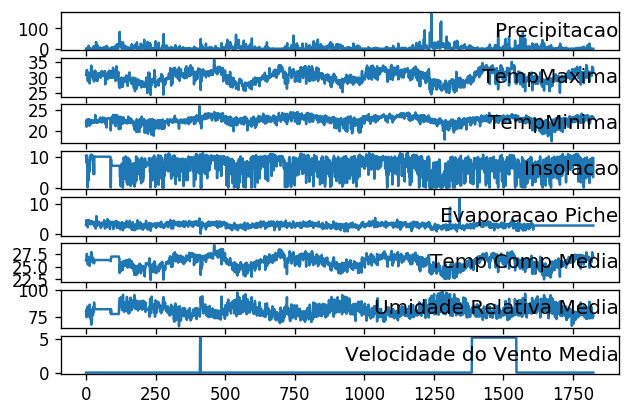

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0759 - mean_squared_error: 1.8228 - val_loss: 0.1686 - val_mean_squared_error: 0.0502
Epoch 2/1000
 - 1s - loss: 0.0852 - mean_squared_error: 0.0119 - val_loss: 0.0648 - val_mean_squared_error: 0.0074
Epoch 3/1000
 - 1s - loss: 0.0418 - mean_squared_error: 0.0029 - val_loss: 0.0397 - val_mean_squared_error: 0.0029
Epoch 4/1000
 - 0s - loss: 0.0382 - mean_squared_error: 0.0026 - val_loss: 0.0456 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 0s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0409 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 1s - loss: 0.0379 - mean_squared_error: 0.0025 - val_loss: 0.0484 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0414 - val_mean_squared_error: 0.0034
Epoch 8/1000
 - 1s - loss: 0.0383 - mean_squared_error: 0.0025 - val_loss: 0.0525 - val_mean_squared_error: 0.0041
Epoch 9/1000
 - 1s - loss: 0.0374 -

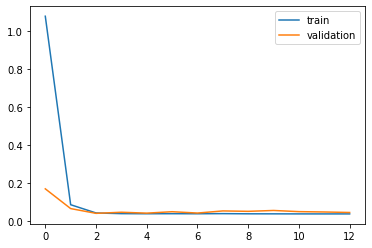


predict: [[30.4166905  23.10961564]]
real:      [[32.2 23.3]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.5075 - mean_squared_error: 3.2070 - val_loss: 0.2722 - val_mean_squared_error: 0.0818
Epoch 2/1000
 - 1s - loss: 0.1376 - mean_squared_error: 0.0305 - val_loss: 0.1086 - val_mean_squared_error: 0.0166
Epoch 3/1000
 - 1s - loss: 0.0537 - mean_squared_error: 0.0048 - val_loss: 0.0574 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 1s - loss: 0.0442 - mean_squared_error: 0.0034 - val_loss: 0.0583 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 0s - loss: 0.0418 - mean_squared_error: 0.0030 - val_loss: 0.0474 - val_mean_squared_error: 0.0032
Epoch 6/1000
 - 1s - loss: 0.0405 - mean_squared_error: 0.0028 - val_loss: 0.0447 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0405 - mean_squared_error: 0.0028 - val_loss: 0.0606 - val_mean_squared_error: 0.0047
Epoch 8/1000
 - 1s - loss: 0.0405 - mean_squared_error: 0.0028 - val_loss: 0.0593 - va

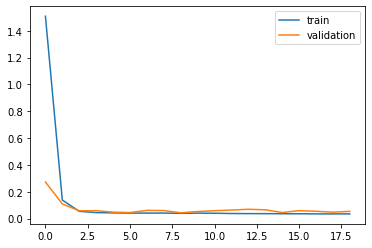


predict: [[30.72610898 23.01477948]]
real:      [[33.  23.1]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2980 - mean_squared_error: 5.7623 - val_loss: 1.0560 - val_mean_squared_error: 1.3553
Epoch 2/1000
 - 1s - loss: 0.3808 - mean_squared_error: 0.2896 - val_loss: 0.0224 - val_mean_squared_error: 5.2121e-04
Epoch 3/1000
 - 0s - loss: 0.0582 - mean_squared_error: 0.0058 - val_loss: 0.0672 - val_mean_squared_error: 0.0074
Epoch 4/1000
 - 0s - loss: 0.0438 - mean_squared_error: 0.0033 - val_loss: 0.0660 - val_mean_squared_error: 0.0046
Epoch 5/1000
 - 0s - loss: 0.0421 - mean_squared_error: 0.0031 - val_loss: 0.0595 - val_mean_squared_error: 0.0038
Epoch 6/1000
 - 0s - loss: 0.0408 - mean_squared_error: 0.0029 - val_loss: 0.0600 - val_mean_squared_error: 0.0037
Epoch 7/1000
 - 0s - loss: 0.0407 - mean_squared_error: 0.0029 - val_loss: 0.0544 - val_mean_squared_error: 0.0035
Epoch 8/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0027 - val_loss: 0.0593 

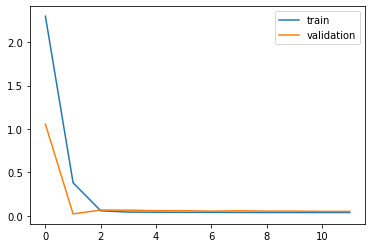


predict: [[32.2097616  22.93139996]]
real:      [[33.2 23.4]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.9045 - mean_squared_error: 4.3991 - val_loss: 0.5827 - val_mean_squared_error: 0.6153
Epoch 2/1000
 - 1s - loss: 0.2086 - mean_squared_error: 0.0860 - val_loss: 0.2040 - val_mean_squared_error: 0.0484
Epoch 3/1000
 - 0s - loss: 0.0711 - mean_squared_error: 0.0082 - val_loss: 0.0866 - val_mean_squared_error: 0.0089
Epoch 4/1000
 - 0s - loss: 0.0452 - mean_squared_error: 0.0034 - val_loss: 0.0712 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 1s - loss: 0.0408 - mean_squared_error: 0.0028 - val_loss: 0.0592 - val_mean_squared_error: 0.0047
Epoch 6/1000
 - 1s - loss: 0.0388 - mean_squared_error: 0.0026 - val_loss: 0.0610 - val_mean_squared_error: 0.0060
Epoch 7/1000
 - 1s - loss: 0.0384 - mean_squared_error: 0.0025 - val_loss: 0.0581 - val_mean_squared_error: 0.0051
Epoch 8/1000
 - 1s - loss: 0.0385 - mean_squared_error: 0.0026 - val_loss: 0.0571 - va

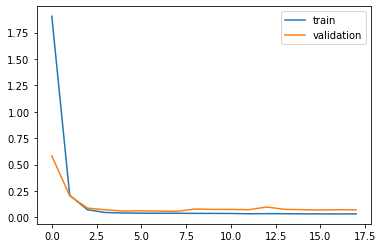


predict: [[30.40574156 23.39430071]]
real:      [[33.  23.6]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.5416 - mean_squared_error: 7.0632 - val_loss: 1.6100 - val_mean_squared_error: 4.3709
Epoch 2/1000
 - 1s - loss: 0.8765 - mean_squared_error: 1.6858 - val_loss: 0.1125 - val_mean_squared_error: 0.0168
Epoch 3/1000
 - 1s - loss: 0.1139 - mean_squared_error: 0.0193 - val_loss: 0.0169 - val_mean_squared_error: 2.9936e-04
Epoch 4/1000
 - 0s - loss: 0.0498 - mean_squared_error: 0.0041 - val_loss: 0.0531 - val_mean_squared_error: 0.0028
Epoch 5/1000
 - 0s - loss: 0.0418 - mean_squared_error: 0.0030 - val_loss: 0.0504 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 0s - loss: 0.0408 - mean_squared_error: 0.0028 - val_loss: 0.0423 - val_mean_squared_error: 0.0019
Epoch 7/1000
 - 1s - loss: 0.0401 - mean_squared_error: 0.0028 - val_loss: 0.0513 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0400 - mean_squared_error: 0.0027 - val_loss: 0.0450 

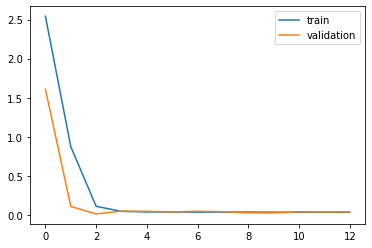


predict: [[31.00464694 24.24797457]]
real:      [[33.4 23.6]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.1777 - mean_squared_error: 5.4175 - val_loss: 0.6637 - val_mean_squared_error: 0.5342
Epoch 2/1000
 - 1s - loss: 0.2157 - mean_squared_error: 0.0899 - val_loss: 0.0994 - val_mean_squared_error: 0.0155
Epoch 3/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0049 - val_loss: 0.0135 - val_mean_squared_error: 2.1089e-04
Epoch 4/1000
 - 1s - loss: 0.0389 - mean_squared_error: 0.0026 - val_loss: 0.0307 - val_mean_squared_error: 0.0013
Epoch 5/1000
 - 1s - loss: 0.0380 - mean_squared_error: 0.0025 - val_loss: 0.0165 - val_mean_squared_error: 4.6427e-04
Epoch 6/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0227 - val_mean_squared_error: 7.2972e-04
Epoch 7/1000
 - 1s - loss: 0.0383 - mean_squared_error: 0.0025 - val_loss: 0.0264 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.0343 - mean_squared_error: 0.0021 - val_loss:

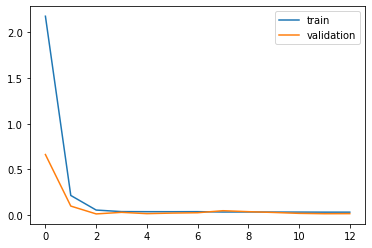


predict: [[30.49541489 23.10033412]]
real:      [[32.  23.5]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.5181 - mean_squared_error: 6.8463 - val_loss: 1.2446 - val_mean_squared_error: 1.5515
Epoch 2/1000
 - 1s - loss: 0.3747 - mean_squared_error: 0.2688 - val_loss: 0.1001 - val_mean_squared_error: 0.0116
Epoch 3/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0067 - val_loss: 7.9918e-04 - val_mean_squared_error: 7.0100e-07
Epoch 4/1000
 - 1s - loss: 0.0412 - mean_squared_error: 0.0028 - val_loss: 0.0185 - val_mean_squared_error: 4.5738e-04
Epoch 5/1000
 - 1s - loss: 0.0397 - mean_squared_error: 0.0026 - val_loss: 0.0068 - val_mean_squared_error: 5.2534e-05
Epoch 6/1000
 - 1s - loss: 0.0393 - mean_squared_error: 0.0026 - val_loss: 0.0278 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 0s - loss: 0.0394 - mean_squared_error: 0.0026 - val_loss: 0.0256 - val_mean_squared_error: 7.2554e-04
Epoch 8/1000
 - 1s - loss: 0.0399 - mean_squared_error: 0.0026 - v

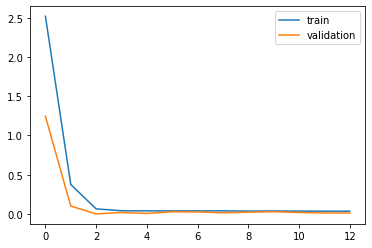


predict: [[30.17493155 22.88343471]]
real:      [[30.5 23.6]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.9570 - mean_squared_error: 10.2483 - val_loss: 2.0327 - val_mean_squared_error: 7.9640
Epoch 2/1000
 - 1s - loss: 1.5746 - mean_squared_error: 4.7369 - val_loss: 0.9645 - val_mean_squared_error: 1.8278
Epoch 3/1000
 - 0s - loss: 0.3920 - mean_squared_error: 0.4452 - val_loss: 0.0179 - val_mean_squared_error: 3.2325e-04
Epoch 4/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0061 - val_loss: 0.0122 - val_mean_squared_error: 1.9059e-04
Epoch 5/1000
 - 1s - loss: 0.0445 - mean_squared_error: 0.0032 - val_loss: 0.0108 - val_mean_squared_error: 2.1598e-04
Epoch 6/1000
 - 1s - loss: 0.0403 - mean_squared_error: 0.0028 - val_loss: 0.0183 - val_mean_squared_error: 3.9224e-04
Epoch 7/1000
 - 0s - loss: 0.0401 - mean_squared_error: 0.0028 - val_loss: 0.0270 - val_mean_squared_error: 7.5386e-04
Epoch 8/1000
 - 1s - loss: 0.0388 - mean_squared_error: 0.0026 - 

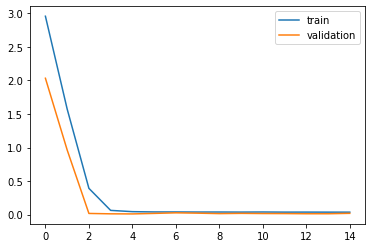


predict: [[31.20776415 22.97237332]]
real:      [[30.5 23.6]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0951 - mean_squared_error: 2.0324 - val_loss: 0.0637 - val_mean_squared_error: 0.0041
Epoch 2/1000
 - 0s - loss: 0.0982 - mean_squared_error: 0.0145 - val_loss: 0.0793 - val_mean_squared_error: 0.0100
Epoch 3/1000
 - 0s - loss: 0.0499 - mean_squared_error: 0.0041 - val_loss: 0.0363 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 1s - loss: 0.0386 - mean_squared_error: 0.0025 - val_loss: 0.0054 - val_mean_squared_error: 3.4505e-05
Epoch 5/1000
 - 1s - loss: 0.0369 - mean_squared_error: 0.0023 - val_loss: 0.0202 - val_mean_squared_error: 4.1171e-04
Epoch 6/1000
 - 1s - loss: 0.0369 - mean_squared_error: 0.0023 - val_loss: 0.0233 - val_mean_squared_error: 5.7005e-04
Epoch 7/1000
 - 0s - loss: 0.0365 - mean_squared_error: 0.0023 - val_loss: 0.0093 - val_mean_squared_error: 8.9705e-05
Epoch 8/1000
 - 0s - loss: 0.0376 - mean_squared_error: 0.0024 - val_l

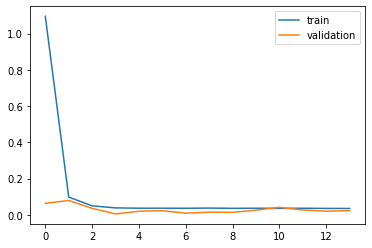


predict: [[30.70451328 23.05767937]]
real:      [[30.8 23.3]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.4649 - mean_squared_error: 6.4431 - val_loss: 1.5777 - val_mean_squared_error: 2.6357
Epoch 2/1000
 - 0s - loss: 0.6103 - mean_squared_error: 0.6623 - val_loss: 0.1487 - val_mean_squared_error: 0.0284
Epoch 3/1000
 - 1s - loss: 0.0765 - mean_squared_error: 0.0100 - val_loss: 0.0589 - val_mean_squared_error: 0.0047
Epoch 4/1000
 - 1s - loss: 0.0461 - mean_squared_error: 0.0037 - val_loss: 0.0050 - val_mean_squared_error: 4.6943e-05
Epoch 5/1000
 - 0s - loss: 0.0403 - mean_squared_error: 0.0028 - val_loss: 0.0086 - val_mean_squared_error: 1.2343e-04
Epoch 6/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0027 - val_loss: 0.0112 - val_mean_squared_error: 1.5525e-04
Epoch 7/1000
 - 1s - loss: 0.0392 - mean_squared_error: 0.0026 - val_loss: 0.0093 - val_mean_squared_error: 9.8188e-05
Epoch 8/1000
 - 1s - loss: 0.0398 - mean_squared_error: 0.0027 - val_l

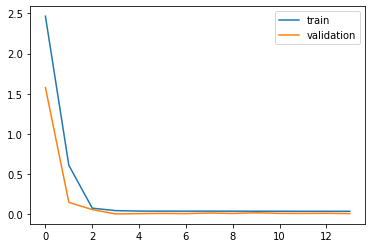


predict: [[30.62351699 22.72406842]]
real:      [[31.  23.4]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.6033 - mean_squared_error: 3.5384 - val_loss: 0.5472 - val_mean_squared_error: 0.5769
Epoch 2/1000
 - 1s - loss: 0.1923 - mean_squared_error: 0.0862 - val_loss: 0.1102 - val_mean_squared_error: 0.0175
Epoch 3/1000
 - 1s - loss: 0.0686 - mean_squared_error: 0.0080 - val_loss: 0.0432 - val_mean_squared_error: 0.0036
Epoch 4/1000
 - 1s - loss: 0.0465 - mean_squared_error: 0.0036 - val_loss: 0.0302 - val_mean_squared_error: 9.2662e-04
Epoch 5/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0029 - val_loss: 0.0248 - val_mean_squared_error: 6.3400e-04
Epoch 6/1000
 - 1s - loss: 0.0408 - mean_squared_error: 0.0028 - val_loss: 0.0179 - val_mean_squared_error: 5.6636e-04
Epoch 7/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0026 - val_loss: 0.0217 - val_mean_squared_error: 5.1485e-04
Epoch 8/1000
 - 1s - loss: 0.0386 - mean_squared_error: 0.0025 - val_l

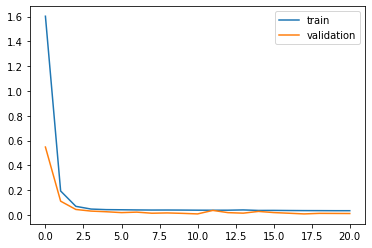


predict: [[30.15814564 22.69183835]]
real:      [[30.7 23.2]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.8998 - mean_squared_error: 4.7788 - val_loss: 0.7810 - val_mean_squared_error: 1.0720
Epoch 2/1000
 - 1s - loss: 0.2726 - mean_squared_error: 0.1996 - val_loss: 0.0895 - val_mean_squared_error: 0.0109
Epoch 3/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0074 - val_loss: 0.0615 - val_mean_squared_error: 0.0038
Epoch 4/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0030 - val_loss: 0.0584 - val_mean_squared_error: 0.0034
Epoch 5/1000
 - 1s - loss: 0.0382 - mean_squared_error: 0.0025 - val_loss: 0.0513 - val_mean_squared_error: 0.0029
Epoch 6/1000
 - 0s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0379 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 0s - loss: 0.0378 - mean_squared_error: 0.0025 - val_loss: 0.0376 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 0s - loss: 0.0385 - mean_squared_error: 0.0026 - val_loss: 0.0606 - va

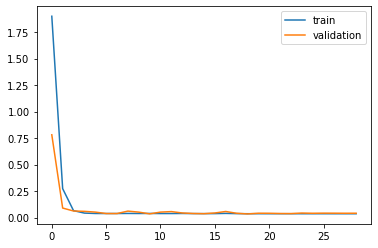


predict: [[29.79990032 22.567822  ]]
real:      [[31.  22.7]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.4130 - mean_squared_error: 3.0299 - val_loss: 0.3964 - val_mean_squared_error: 0.2132
Epoch 2/1000
 - 1s - loss: 0.1842 - mean_squared_error: 0.0619 - val_loss: 0.0437 - val_mean_squared_error: 0.0020
Epoch 3/1000
 - 1s - loss: 0.0480 - mean_squared_error: 0.0037 - val_loss: 0.0042 - val_mean_squared_error: 1.7885e-05
Epoch 4/1000
 - 1s - loss: 0.0399 - mean_squared_error: 0.0027 - val_loss: 0.0205 - val_mean_squared_error: 5.5834e-04
Epoch 5/1000
 - 1s - loss: 0.0379 - mean_squared_error: 0.0024 - val_loss: 0.0422 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 1s - loss: 0.0375 - mean_squared_error: 0.0024 - val_loss: 0.0313 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0359 - mean_squared_error: 0.0022 - val_loss: 0.0419 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 1s - loss: 0.0359 - mean_squared_error: 0.0022 - val_loss: 0.0

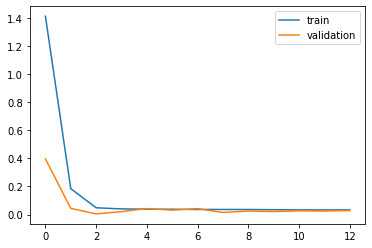


predict: [[29.3741483  22.58604586]]
real:      [[31.6 21.9]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8987 - mean_squared_error: 9.2310 - val_loss: 2.2669 - val_mean_squared_error: 6.7092
Epoch 2/1000
 - 0s - loss: 1.7628 - mean_squared_error: 5.3767 - val_loss: 1.2585 - val_mean_squared_error: 3.1590
Epoch 3/1000
 - 0s - loss: 1.2311 - mean_squared_error: 2.8058 - val_loss: 0.9803 - val_mean_squared_error: 1.9160
Epoch 4/1000
 - 0s - loss: 0.5577 - mean_squared_error: 0.7745 - val_loss: 0.1113 - val_mean_squared_error: 0.0247
Epoch 5/1000
 - 0s - loss: 0.0820 - mean_squared_error: 0.0141 - val_loss: 0.0590 - val_mean_squared_error: 0.0063
Epoch 6/1000
 - 0s - loss: 0.0437 - mean_squared_error: 0.0034 - val_loss: 0.0235 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0265 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 0s - loss: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0231 - va

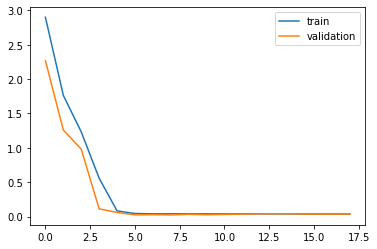


predict: [[29.35700465 22.93944063]]
real:      [[29.2 22.6]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.4470 - mean_squared_error: 6.3086 - val_loss: 1.4687 - val_mean_squared_error: 2.1858
Epoch 2/1000
 - 1s - loss: 0.5833 - mean_squared_error: 0.5574 - val_loss: 0.0682 - val_mean_squared_error: 0.0048
Epoch 3/1000
 - 1s - loss: 0.0689 - mean_squared_error: 0.0081 - val_loss: 0.0684 - val_mean_squared_error: 0.0064
Epoch 4/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0033 - val_loss: 0.0344 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 0s - loss: 0.0401 - mean_squared_error: 0.0028 - val_loss: 0.0561 - val_mean_squared_error: 0.0032
Epoch 6/1000
 - 1s - loss: 0.0397 - mean_squared_error: 0.0027 - val_loss: 0.0340 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 0s - loss: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0455 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 0s - loss: 0.0372 - mean_squared_error: 0.0024 - val_loss: 0.0423 - va

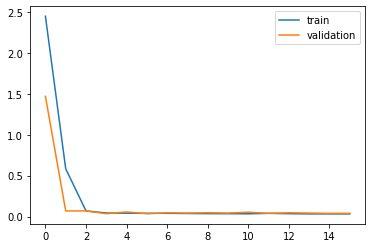


predict: [[29.97194719 22.13769351]]
real:      [[28.6 23.1]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2880 - mean_squared_error: 6.2488 - val_loss: 1.1822 - val_mean_squared_error: 2.7100
Epoch 2/1000
 - 1s - loss: 0.5253 - mean_squared_error: 0.7380 - val_loss: 0.1399 - val_mean_squared_error: 0.0306
Epoch 3/1000
 - 1s - loss: 0.0724 - mean_squared_error: 0.0109 - val_loss: 0.0813 - val_mean_squared_error: 0.0075
Epoch 4/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0032 - val_loss: 0.0405 - val_mean_squared_error: 0.0017
Epoch 5/1000
 - 1s - loss: 0.0391 - mean_squared_error: 0.0026 - val_loss: 0.0407 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0379 - mean_squared_error: 0.0025 - val_loss: 0.0428 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0522 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0373 - mean_squared_error: 0.0024 - val_loss: 0.0262 - va

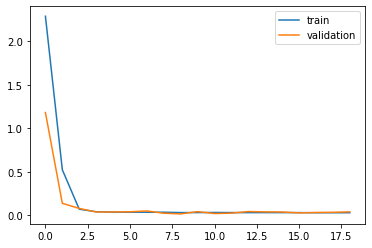


predict: [[31.67174102 22.65620008]]
real:      [[31.6 21.8]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3510 - mean_squared_error: 6.4131 - val_loss: 1.2134 - val_mean_squared_error: 2.7089
Epoch 2/1000
 - 1s - loss: 0.8332 - mean_squared_error: 1.3245 - val_loss: 0.3084 - val_mean_squared_error: 0.1744
Epoch 3/1000
 - 1s - loss: 0.1195 - mean_squared_error: 0.0288 - val_loss: 0.0276 - val_mean_squared_error: 7.8263e-04
Epoch 4/1000
 - 1s - loss: 0.0458 - mean_squared_error: 0.0034 - val_loss: 0.0139 - val_mean_squared_error: 3.2146e-04
Epoch 5/1000
 - 1s - loss: 0.0382 - mean_squared_error: 0.0025 - val_loss: 0.0235 - val_mean_squared_error: 5.6779e-04
Epoch 6/1000
 - 1s - loss: 0.0382 - mean_squared_error: 0.0025 - val_loss: 0.0032 - val_mean_squared_error: 1.0104e-05
Epoch 7/1000
 - 1s - loss: 0.0373 - mean_squared_error: 0.0024 - val_loss: 0.0081 - val_mean_squared_error: 1.0230e-04
Epoch 8/1000
 - 1s - loss: 0.0371 - mean_squared_error: 0.0024 - v

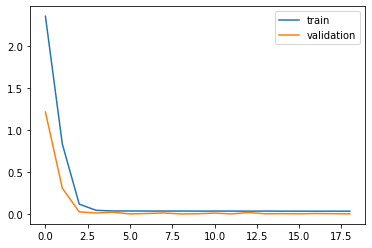


predict: [[30.39737141 22.98569976]]
real:      [[31.8 22. ]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.6923 - mean_squared_error: 3.4348 - val_loss: 0.1298 - val_mean_squared_error: 0.0179
Epoch 2/1000
 - 0s - loss: 0.1508 - mean_squared_error: 0.0371 - val_loss: 0.0604 - val_mean_squared_error: 0.0043
Epoch 3/1000
 - 0s - loss: 0.0582 - mean_squared_error: 0.0055 - val_loss: 0.0249 - val_mean_squared_error: 7.8400e-04
Epoch 4/1000
 - 0s - loss: 0.0417 - mean_squared_error: 0.0029 - val_loss: 0.0051 - val_mean_squared_error: 2.6481e-05
Epoch 5/1000
 - 0s - loss: 0.0392 - mean_squared_error: 0.0026 - val_loss: 0.0144 - val_mean_squared_error: 2.3674e-04
Epoch 6/1000
 - 0s - loss: 0.0387 - mean_squared_error: 0.0026 - val_loss: 0.0223 - val_mean_squared_error: 5.6343e-04
Epoch 7/1000
 - 0s - loss: 0.0389 - mean_squared_error: 0.0026 - val_loss: 0.0152 - val_mean_squared_error: 2.3063e-04
Epoch 8/1000
 - 0s - loss: 0.0380 - mean_squared_error: 0.0025 - v

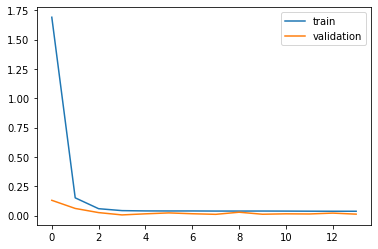


predict: [[30.19842768 21.78201291]]
real:      [[30.4 23. ]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7935 - mean_squared_error: 7.9225 - val_loss: 2.2156 - val_mean_squared_error: 4.9101
Epoch 2/1000
 - 1s - loss: 1.3829 - mean_squared_error: 2.1884 - val_loss: 0.3734 - val_mean_squared_error: 0.1669
Epoch 3/1000
 - 1s - loss: 0.1318 - mean_squared_error: 0.0308 - val_loss: 0.1287 - val_mean_squared_error: 0.0166
Epoch 4/1000
 - 1s - loss: 0.0506 - mean_squared_error: 0.0042 - val_loss: 0.0371 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0413 - mean_squared_error: 0.0029 - val_loss: 0.0414 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0391 - mean_squared_error: 0.0026 - val_loss: 0.0413 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0386 - mean_squared_error: 0.0026 - val_loss: 0.0485 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 1s - loss: 0.0383 - mean_squared_error: 0.0025 - val_loss: 0.0428 - va

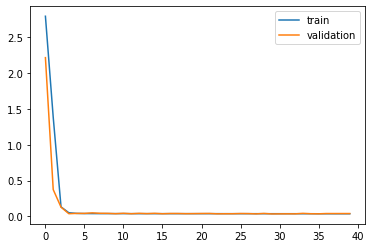


predict: [[29.69138951 22.79332272]]
real:      [[30.8 22.5]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3816 - mean_squared_error: 6.9148 - val_loss: 1.4827 - val_mean_squared_error: 3.9732
Epoch 2/1000
 - 1s - loss: 0.8149 - mean_squared_error: 1.4756 - val_loss: 0.0459 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 1s - loss: 0.0850 - mean_squared_error: 0.0147 - val_loss: 0.0542 - val_mean_squared_error: 0.0046
Epoch 4/1000
 - 0s - loss: 0.0467 - mean_squared_error: 0.0039 - val_loss: 0.0160 - val_mean_squared_error: 2.5780e-04
Epoch 5/1000
 - 1s - loss: 0.0389 - mean_squared_error: 0.0026 - val_loss: 0.0152 - val_mean_squared_error: 2.3254e-04
Epoch 6/1000
 - 1s - loss: 0.0381 - mean_squared_error: 0.0025 - val_loss: 0.0061 - val_mean_squared_error: 6.7187e-05
Epoch 7/1000
 - 1s - loss: 0.0383 - mean_squared_error: 0.0025 - val_loss: 0.0040 - val_mean_squared_error: 1.7038e-05
Epoch 8/1000
 - 1s - loss: 0.0383 - mean_squared_error: 0.0025 - val_l

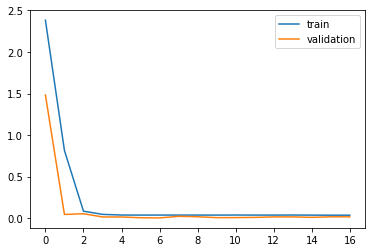


predict: [[29.0849868 22.1659771]]
real:      [[31.8 23.8]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.4647 - mean_squared_error: 3.2156 - val_loss: 0.2618 - val_mean_squared_error: 0.1041
Epoch 2/1000
 - 1s - loss: 0.1544 - mean_squared_error: 0.0436 - val_loss: 0.0506 - val_mean_squared_error: 0.0026
Epoch 3/1000
 - 1s - loss: 0.0496 - mean_squared_error: 0.0038 - val_loss: 0.0210 - val_mean_squared_error: 4.5013e-04
Epoch 4/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0028 - val_loss: 0.0161 - val_mean_squared_error: 4.1366e-04
Epoch 5/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0024 - val_loss: 0.0248 - val_mean_squared_error: 6.9090e-04
Epoch 6/1000
 - 1s - loss: 0.0370 - mean_squared_error: 0.0024 - val_loss: 0.0182 - val_mean_squared_error: 5.2487e-04
Epoch 7/1000
 - 1s - loss: 0.0366 - mean_squared_error: 0.0024 - val_loss: 0.0370 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 1s - loss: 0.0373 - mean_squared_error: 0.0024 - val_los

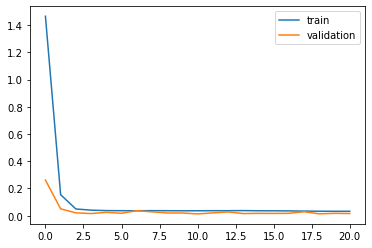


predict: [[30.50701106 23.0255116 ]]
real:      [[29.9 22.7]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.4356 - mean_squared_error: 6.6442 - val_loss: 1.5828 - val_mean_squared_error: 4.1171
Epoch 2/1000
 - 1s - loss: 1.3305 - mean_squared_error: 3.1789 - val_loss: 1.0930 - val_mean_squared_error: 2.3678
Epoch 3/1000
 - 1s - loss: 0.8717 - mean_squared_error: 1.4823 - val_loss: 0.4539 - val_mean_squared_error: 0.3310
Epoch 4/1000
 - 1s - loss: 0.1447 - mean_squared_error: 0.0507 - val_loss: 0.0791 - val_mean_squared_error: 0.0067
Epoch 5/1000
 - 1s - loss: 0.0483 - mean_squared_error: 0.0037 - val_loss: 0.0555 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 1s - loss: 0.0387 - mean_squared_error: 0.0026 - val_loss: 0.0482 - val_mean_squared_error: 0.0031
Epoch 7/1000
 - 1s - loss: 0.0370 - mean_squared_error: 0.0024 - val_loss: 0.0357 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 1s - loss: 0.0372 - mean_squared_error: 0.0024 - val_loss: 0.0406 - va

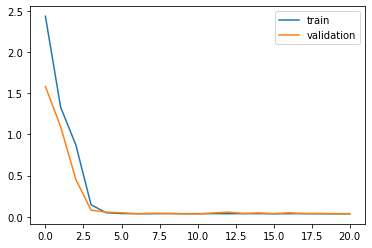


predict: [[30.83578079 23.2456146 ]]
real:      [[30.6 23.5]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.5909 - mean_squared_error: 3.5312 - val_loss: 0.1502 - val_mean_squared_error: 0.0276
Epoch 2/1000
 - 1s - loss: 0.1455 - mean_squared_error: 0.0319 - val_loss: 0.1381 - val_mean_squared_error: 0.0196
Epoch 3/1000
 - 1s - loss: 0.0551 - mean_squared_error: 0.0050 - val_loss: 0.0468 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0030 - val_loss: 0.0449 - val_mean_squared_error: 0.0033
Epoch 5/1000
 - 1s - loss: 0.0400 - mean_squared_error: 0.0027 - val_loss: 0.0504 - val_mean_squared_error: 0.0039
Epoch 6/1000
 - 1s - loss: 0.0392 - mean_squared_error: 0.0026 - val_loss: 0.0413 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.0392 - mean_squared_error: 0.0027 - val_loss: 0.0551 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.0365 - mean_squared_error: 0.0023 - val_loss: 0.0551 - va

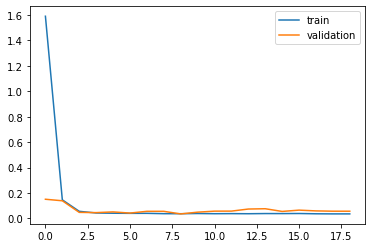


predict: [[31.51717365 23.94789585]]
real:      [[32.8 23.4]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.6352 - mean_squared_error: 3.6233 - val_loss: 0.5177 - val_mean_squared_error: 0.3968
Epoch 2/1000
 - 1s - loss: 0.1734 - mean_squared_error: 0.0573 - val_loss: 0.1255 - val_mean_squared_error: 0.0236
Epoch 3/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0056 - val_loss: 0.0319 - val_mean_squared_error: 0.0010
Epoch 4/1000
 - 1s - loss: 0.0429 - mean_squared_error: 0.0032 - val_loss: 0.0345 - val_mean_squared_error: 0.0014
Epoch 5/1000
 - 1s - loss: 0.0413 - mean_squared_error: 0.0030 - val_loss: 0.0470 - val_mean_squared_error: 0.0024
Epoch 6/1000
 - 1s - loss: 0.0403 - mean_squared_error: 0.0028 - val_loss: 0.0376 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0392 - mean_squared_error: 0.0026 - val_loss: 0.0404 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0380 - mean_squared_error: 0.0025 - val_loss: 0.0371 - va

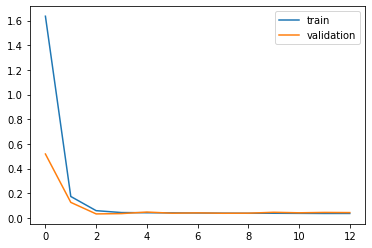


predict: [[31.08828716 22.81360585]]
real:      [[33.4 23.6]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9012 - mean_squared_error: 8.7215 - val_loss: 2.4912 - val_mean_squared_error: 7.0151
Epoch 2/1000
 - 1s - loss: 1.9244 - mean_squared_error: 5.7454 - val_loss: 1.6618 - val_mean_squared_error: 4.8152
Epoch 3/1000
 - 1s - loss: 1.3860 - mean_squared_error: 3.6795 - val_loss: 1.0961 - val_mean_squared_error: 2.2849
Epoch 4/1000
 - 1s - loss: 0.6272 - mean_squared_error: 0.8786 - val_loss: 0.0847 - val_mean_squared_error: 0.0108
Epoch 5/1000
 - 1s - loss: 0.0728 - mean_squared_error: 0.0083 - val_loss: 0.0759 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 1s - loss: 0.0417 - mean_squared_error: 0.0029 - val_loss: 0.0710 - val_mean_squared_error: 0.0072
Epoch 7/1000
 - 1s - loss: 0.0385 - mean_squared_error: 0.0026 - val_loss: 0.0731 - val_mean_squared_error: 0.0069
Epoch 8/1000
 - 1s - loss: 0.0378 - mean_squared_error: 0.0025 - val_loss: 0.0697 - va

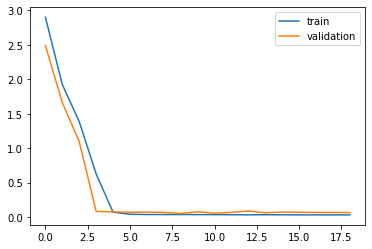


predict: [[30.9886269  23.37298836]]
real:      [[32.2 23.8]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.0369 - mean_squared_error: 4.6788 - val_loss: 0.6660 - val_mean_squared_error: 0.4442
Epoch 2/1000
 - 1s - loss: 0.1874 - mean_squared_error: 0.0575 - val_loss: 0.0828 - val_mean_squared_error: 0.0096
Epoch 3/1000
 - 1s - loss: 0.0549 - mean_squared_error: 0.0050 - val_loss: 0.0581 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0030 - val_loss: 0.0420 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0380 - mean_squared_error: 0.0025 - val_loss: 0.0292 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0453 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 0s - loss: 0.0374 - mean_squared_error: 0.0024 - val_loss: 0.0385 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0025 - val_loss: 0.0306 - va

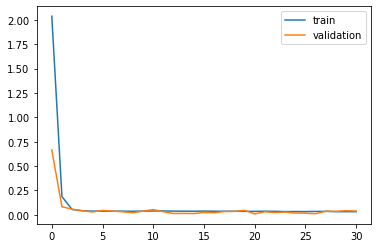


predict: [[31.59229089 23.47094851]]
real:      [[34.  23.7]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.0544 - mean_squared_error: 4.7697 - val_loss: 0.6026 - val_mean_squared_error: 0.3819
Epoch 2/1000
 - 1s - loss: 0.1951 - mean_squared_error: 0.0640 - val_loss: 0.0275 - val_mean_squared_error: 8.6520e-04
Epoch 3/1000
 - 1s - loss: 0.0526 - mean_squared_error: 0.0044 - val_loss: 0.0404 - val_mean_squared_error: 0.0016
Epoch 4/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0026 - val_loss: 0.0272 - val_mean_squared_error: 9.0041e-04
Epoch 5/1000
 - 1s - loss: 0.0381 - mean_squared_error: 0.0025 - val_loss: 0.0249 - val_mean_squared_error: 7.1316e-04
Epoch 6/1000
 - 1s - loss: 0.0382 - mean_squared_error: 0.0025 - val_loss: 0.0133 - val_mean_squared_error: 2.9093e-04
Epoch 7/1000
 - 1s - loss: 0.0378 - mean_squared_error: 0.0024 - val_loss: 0.0133 - val_mean_squared_error: 2.3641e-04
Epoch 8/1000
 - 1s - loss: 0.0379 - mean_squared_error: 0.0025 - v

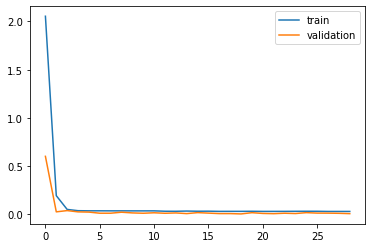


predict: [[31.53808164 23.62819667]]
real:      [[31.6 23.7]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.7491 - mean_squared_error: 3.7465 - val_loss: 0.5040 - val_mean_squared_error: 0.3716
Epoch 2/1000
 - 1s - loss: 0.1934 - mean_squared_error: 0.0642 - val_loss: 0.1220 - val_mean_squared_error: 0.0183
Epoch 3/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0065 - val_loss: 0.0273 - val_mean_squared_error: 7.5084e-04
Epoch 4/1000
 - 1s - loss: 0.0417 - mean_squared_error: 0.0029 - val_loss: 0.0281 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 1s - loss: 0.0399 - mean_squared_error: 0.0027 - val_loss: 0.0232 - val_mean_squared_error: 5.6284e-04
Epoch 6/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0027 - val_loss: 0.0249 - val_mean_squared_error: 6.9234e-04
Epoch 7/1000
 - 0s - loss: 0.0380 - mean_squared_error: 0.0025 - val_loss: 0.0249 - val_mean_squared_error: 6.2141e-04
Epoch 8/1000
 - 1s - loss: 0.0377 - mean_squared_error: 0.0025 - val_l

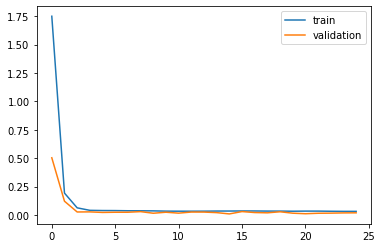


predict: [[30.84436651 23.35010969]]
real:      [[31.6 23.4]]

Train on 1734 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.4935 - mean_squared_error: 6.6529 - val_loss: 1.3731 - val_mean_squared_error: 1.9153
Epoch 2/1000
 - 1s - loss: 0.4959 - mean_squared_error: 0.4264 - val_loss: 0.1357 - val_mean_squared_error: 0.0203
Epoch 3/1000
 - 1s - loss: 0.0856 - mean_squared_error: 0.0131 - val_loss: 0.0336 - val_mean_squared_error: 0.0014
Epoch 4/1000
 - 1s - loss: 0.0440 - mean_squared_error: 0.0032 - val_loss: 0.0062 - val_mean_squared_error: 6.0626e-05
Epoch 5/1000
 - 1s - loss: 0.0380 - mean_squared_error: 0.0025 - val_loss: 0.0184 - val_mean_squared_error: 3.4257e-04
Epoch 6/1000
 - 1s - loss: 0.0391 - mean_squared_error: 0.0026 - val_loss: 0.0096 - val_mean_squared_error: 9.5416e-05
Epoch 7/1000
 - 1s - loss: 0.0371 - mean_squared_error: 0.0024 - val_loss: 0.0149 - val_mean_squared_error: 2.2365e-04
Epoch 8/1000
 - 0s - loss: 0.0370 - mean_squared_error: 0.0024 - val_l

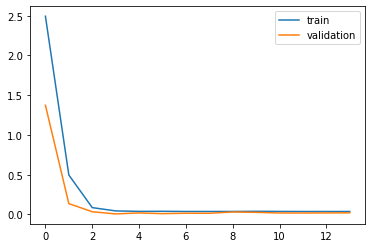


predict: [[29.9771757  22.87918148]]
real:      [[29.9 23.3]]

Train on 1733 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.6591 - mean_squared_error: 7.4434 - val_loss: 1.2916 - val_mean_squared_error: 1.7735
Epoch 2/1000
 - 1s - loss: 0.4410 - mean_squared_error: 0.3597 - val_loss: 0.2011 - val_mean_squared_error: 0.0611
Epoch 3/1000
 - 1s - loss: 0.0759 - mean_squared_error: 0.0108 - val_loss: 0.0482 - val_mean_squared_error: 0.0044
Epoch 4/1000
 - 1s - loss: 0.0423 - mean_squared_error: 0.0030 - val_loss: 0.0304 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 1s - loss: 0.0385 - mean_squared_error: 0.0026 - val_loss: 0.0375 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0027 - val_loss: 0.0384 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 1s - loss: 0.0380 - mean_squared_error: 0.0025 - val_loss: 0.0393 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0378 - mean_squared_error: 0.0025 - val_loss: 0.0426 - va

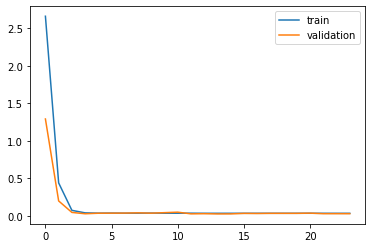


predict: [[29.92476065 23.00218653]]
real:      [[29.9 22.6]]

Train and validation time: 7.07 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 1.976
Test STANDART-DEVIATION ------------ 0.8746
Test MEAN-ABSOLUTE-ERROR ----------- 1.101
Test MEDIAN-ABSOLUTE-ERROR --------- 1.049

Errors
2018-12-31 = 1.7833094980983581
2018-12-30 = 2.2738910246257404
2018-12-29 = 0.9902383996908668
2018-12-28 = 2.5942584415633796
2018-12-27 = 2.3953530566108974
2018-12-26 = 1.504585110738585
2018-12-25 = 0.3250684479614634
2018-12-24 = 0.7077641525238043
2018-12-23 = 0.09548672323895957
2018-12-22 = 0.37648300608917395
2018-12-21 = 0.5418543578499531
2018-12-20 = 1.2000996794491527
2018-12-19 = 2.225851701110834
2018-12-18 = 0.15700464807624215
2018-12-17 = 1.3719471861629664
2018-12-16 = 0.07174101762176832
2018-12-15 = 1.402628588301063
2018-12-14 = 0.20157232013552573
2018-12-13 = 1.1086104858400105
2018-12-12 = 2.7150132000795395
2018-12-11 = 0.607011061662103
2018-12-10 =

In [16]:
def main():
    input_path = '../data_in/'+city+'.csv'
    output_path = format_dataset(input_path)
    dataset = load_dataset(output_path)
    values = dataset.values
    plot_columns(dataset, values)

    # to get index the last 30 days
    days_to_predict = list(dataset.index[-30:])

    values_scaled = np.log1p(values)
    dataset_scaled = DataFrame(values_scaled)
    dataset_scaled.index = dataset.index
    dataset_scaled.columns = dataset.columns

    inicio = time.time()
    result = NCV(dataset_scaled, days_to_predict)
    fim = time.time()
    print('Train and validation time: {} minutes\n'.format(round((fim - inicio)/60,2)))

    y_hats = result[0]
    y_tests = result[1]

    metrics(y_hats, y_tests, days_to_predict)
    
if __name__ == "__main__":
    main()